Load raster files for "basic forest data" and "tree height".

In [1]:
import gdal
import numpy as np
import nfhelpers as nf

# For 12.5m data only, lower res. than 2m data.
basic_forest_data_bands = {
    "volume": 1,
    "mean_height": 2,
    "basal_area": 3,
    "mean_diameter": 4,
    "biomass": 5,
    "upper_height": 6,
    "crown_coverage": 7
}

no_data_value = -1

# First file, multiple rasters, 12.5 m data
basic_forest_data_file = gdal.Open("SFA_files/SGD/SGD.vrt")
    
# Second file, single raster, 2 m data
tree_height_file = gdal.Open("SFA_files/TH/TH.vrt")

----------------
Load all the sample areas from Excel-file.

In [2]:
import pandas as pd

sample_areas_file = pd.ExcelFile("SFA_files/provpunkter_svref99.xls")
sheet = sample_areas_file.parse(0)

N_col = sheet["N"]
E_col = sheet["E"]
ID_col = sheet["OBJECTID"]
CLASS_col = sheet["pb"]

sampleAreas = []

for i in range(len(ID_col)):
    sampleAreas.append( nf.SampleArea(ID_col[i], CLASS_col[i], coords=(N_col[i], E_col[i])) )

In [3]:
from osgeo import gdal,ogr,osr

def GetExtent(gt,cols,rows):
    ext=[]
    xarr=[0,cols]
    yarr=[0,rows]

    for px in xarr:
        for py in yarr:
            x=gt[0]+(px*gt[1])+(py*gt[2])
            y=gt[3]+(px*gt[4])+(py*gt[5])
            ext.append([x,y])
            print(x,y)
        yarr.reverse()
    return ext

def ReprojectCoords(coords,src_srs,tgt_srs):
    trans_coords=[]
    transform = osr.CoordinateTransformation( src_srs, tgt_srs)
    for x,y in coords:
        x,y,z = transform.TransformPoint(x,y)
        trans_coords.append([x,y])
    return trans_coords

raster=r'SFA_files/TH/TH.vrt'
ds=gdal.Open(raster)

gt=ds.GetGeoTransform()
cols = ds.RasterXSize
rows = ds.RasterYSize
ext=GetExtent(gt,cols,rows)

src_srs=osr.SpatialReference()
src_srs.ImportFromWkt(ds.GetProjection())
#tgt_srs=osr.SpatialReference()
#tgt_srs.ImportFromEPSG(4326)
tgt_srs = src_srs.CloneGeogCS()

geo_ext=ReprojectCoords(ext,src_srs,tgt_srs)

265000.0 7672500.0
265000.0 6132500.0
922500.0 6132500.0
922500.0 7672500.0


------------

Extracts data around each sample area coordinate in a given radius.

Does this for each raster and saves them back into the given sample area.

Done!


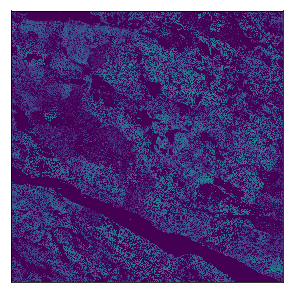

In [5]:
import nfhelpers as nf
import tqdm
import math
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt

radii_in_meters = [25, 50]

# Progress bar
pbar = tqdm.tqdm_notebook(total=len(sampleAreas))


for sampleArea in sampleAreas:
    
    # Pre-define structures to hold raster data
    sampleArea.rasters["height"] = {}
    sampleArea.rasters["height_smoothed"] = {}
    for key in [*basic_forest_data_bands]:
        sampleArea.rasters[key] = {}
        
    for radius_in_meters in radii_in_meters:
        
        # Basic forest data
        geo_transform = basic_forest_data_file.GetGeoTransform()
        radius = radius_in_meters/abs(geo_transform[1])
        area_buffer = math.ceil(radius) + 5
        point = nf.to_pixel_position(sampleArea.coords, geo_transform)
        cx = point[0]
        cy = point[1]
        area_buffer_point = ((cx-int(cx)+area_buffer), (cy-int(cy)+area_buffer))
        
        for key in [*basic_forest_data_bands]:
            band = basic_forest_data_file.GetRasterBand(basic_forest_data_bands[key])
            area_buffer_data = band.ReadAsArray(int(cx)-area_buffer, int(cy)-area_buffer, 2*area_buffer, 2*area_buffer).astype(np.float)
            circle_mask_small = nf.create_circular_mask(area_buffer*2, area_buffer*2, area_buffer_point, radius)
            points_in_radius = area_buffer_data[circle_mask_small == True]
            sampleArea.rasters[key][radius_in_meters] = points_in_radius

            
            
        # Tree height
        geo_transform = tree_height_file.GetGeoTransform()
        radius = radius_in_meters/abs(geo_transform[1])
        band = tree_height_file.GetRasterBand(1)
        area_buffer = math.ceil(radius) + 5
        point = nf.to_pixel_position(sampleArea.coords, geo_transform)
        cx = point[0]
        cy = point[1]
        area_buffer_point = ((cx-int(cx)+area_buffer), (cy-int(cy)+area_buffer))
        
        area_buffer_data = band.ReadAsArray(int(cx)-area_buffer, int(cy)-area_buffer, 2*area_buffer, 2*area_buffer).astype(np.float)
        circle_mask_small = nf.create_circular_mask(area_buffer*2, area_buffer*2, area_buffer_point, radius)
        points_in_radius = area_buffer_data[circle_mask_small == True]
        
        # interpolate data with billinear interpolation to 8x size (2m => 0.25m)
        interpolated_data = zoom(area_buffer_data, 8, order=1)
        # smooth data with kernel = 1
        gauss_data = gaussian_filter(interpolated_data, 1)
        circle_mask_large = nf.create_circular_mask(gauss_data.shape[0], gauss_data.shape[1], (area_buffer_point[0]*8, area_buffer_point[1]*8), radius*8)
        cut_out = np.array(gauss_data)
        cut_out[~circle_mask_large] = None
        
        sampleArea.rasters["height"][radius_in_meters] = points_in_radius
        sampleArea.rasters["height_smoothed"][radius_in_meters] = cut_out

    pbar.update(1)

print("Done!")

-------------

Filters out sample areas with any non-values in any raster.

In [4]:
filtered_sampleAreas = []

for sampleArea in sampleAreas:
    is_valid = True
    for key in [*sampleArea.rasters]:
        if key == "height_smoothed":
            continue
        for radius_in_meters in radii_in_meters:
            if any(i == no_data_value for i in sampleArea.rasters[key][radius_in_meters]):
                is_valid = False
                break
        if not is_valid:
            break
    if is_valid:
        filtered_sampleAreas.append(sampleArea)

print(f"Before filtering: {len(sampleAreas)}")
print(f"After filtering: {len(filtered_sampleAreas)}")

Before filtering: 4175
After filtering: 4054


------------

Saves all the extracted data to file.

In [6]:
np.save("numpy_objects/sampleAreas_with_raw_data", filtered_sampleAreas)